* Загрузите датасет с Kaggle : **https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data?select=loan_data.csv**

* Посмотрите описание данных. Сконструируйте содержательно **интерпретируемую модель** для предсказания бинарной переменной **loan_status** по значениям двух или более интервальных и двух или более категориальных переменных. 

* Загрузите необходимые библиотеки. Для подгонки логистической регрессии используйте библиотеку **statsmodels** (необходимо использовать **patsy** ЛИБО добавлять константу вручную, sm.add_constant(X)). Patsy превратит категориальные предикторы в набор dummies, если в формуле указать C(предиктор), как-то так.

* Делить датафрейм на обучающую и тестовую выборки не обязательно (но крайне желательно), но в этом случае проверять качество предсказания следует на матрице X; для простых линейных моделей это допустимо.

* Интерпретируйте результаты

При возникновении технических проблем есть, конечно, Google и Edge (легче найти релевантный совет, если указать функцию, вызвавшую ошибку, и скопировать/поместить текст сообщения об ошибки). Но я также у аппарата

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import plotly.express as px

In [2]:
# !pip install kaggle  следует установить библиотеку
# # Аутентификация, см #https://github.com/Kaggle/kaggle-api     
# API -- create new token
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Инициализация API
api = KaggleApi()
api.authenticate()

os.environ['vitalysramblerru'] = ''  # указываю свой username
os.environ[''] = ''       # указываю свой токен
import kaggle
kaggle.api.authenticate()

In [3]:
# Загрузка датасета
dataset = 'taweilo/loan-approval-classification-data'  # Укажите путь к датасету
api.dataset_download_files(dataset, path='.', unzip=True)  # Загрузка и распаковка

Dataset URL: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data


In [4]:
# Загрузка данных
data = pd.read_csv('loan_data.csv')  # Убедитесь, что файл загружен в текущую директорию

# Просмотр первых строк данных
data.head(3).T

,0,1,2
person_age,22.0,21.0,25.0
person_gender,female,female,female
person_education,Master,High School,High School
person_income,71948.0,12282.0,12438.0
person_emp_exp,0,0,3
person_home_ownership,RENT,OWN,MORTGAGE
loan_amnt,35000.0,1000.0,5500.0
loan_intent,PERSONAL,EDUCATION,MEDICAL
loan_int_rate,16.02,11.14,12.87
loan_percent_income,0.49,0.08,0.44


In [5]:
# Получение списка столбцов
columns_list = data.columns.tolist()
columns_list

['person_age',
 'person_gender',
 'person_education',
 'person_income',
 'person_emp_exp',
 'person_home_ownership',
 'loan_amnt',
 'loan_intent',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'credit_score',
 'previous_loan_defaults_on_file',
 'loan_status']

In [6]:
data.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [7]:
data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.76,6.05,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.05,80422.50,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.41,6.06,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.16,6314.89,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.01,2.98,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.14,0.09,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.87,3.88,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.61,50.44,390.00,601.00,640.00,670.00,850.00
loan_status,45000.0,0.22,0.42,0.00,0.00,0.00,0.00,1.00


### Анализ описательной статистики

    Интервальные переменные:
    
    1) person_age: Средний возраст составляет около 27.76 лет, с минимальным значением 20 и максимальным 144. Это может указывать на наличие выбросов (например, 144 года), что стоит учитывать при построении модели.
    
    2) person_income: Средний доход составляет 80,319.05, с максимальным значением 7,200,766.00. Это также может указывать на выбросы, которые могут повлиять на модель.
    
    3) loan_amnt: Средняя сумма займа составляет 9,583.16, что может быть полезной переменной.
    
    4) loan_int_rate: Средняя процентная ставка 11.01% может быть важной для оценки вероятности одобрения займа.
    
    5) credit_score: Средний кредитный рейтинг 632.61 также является важным показателем.

### Выбор переменных для модели

    На основе описательной статистики, можно сделать следующие выводы:

    1) Интервальные переменные:
    
loan_amnt, person_income, и, возможно, loan_int_rate и credit_score. Однако стоит проверить наличие выбросов и, возможно, применить логарифмическое преобразование для переменных с высокой дисперсией (например, person_income).
    
    2) Категориальные переменные:
    
person_gender, person_education, и person_home_ownership. Эти переменные могут быть важными для предсказания loan_status.

In [8]:
#С учетом вышеизложенного, формула для модели может выглядеть следующим образом:
formula = 'loan_status ~ loan_amnt + person_income + loan_int_rate + credit_score + C(person_gender) + C(person_education) + C(person_home_ownership)'


In [9]:
# Создание матрицы признаков и вектора целевой переменной
y, X = patsy.dmatrices(formula, data, return_type='dataframe')

# Добавление константы
X = sm.add_constant(X)

In [10]:
# Разделение данных на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Построение модели

Теперь мы можем подогнать модель логистической регрессии к нашим данным.

In [11]:
# Создание и подгонка модели логистической регрессии

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

C:\Users\Professional\extra_path\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=10000)

### Точность прогноза логистической модели

In [12]:
# Получаем прогнозы от модели
predictions = model.predict(X_test)

# Измеряем точность результата
model_score = accuracy_score(y_test, predictions)

# Выводим точность модели
print(f'Accuracy of the model: {model_score:.2f}')

Accuracy of the model: 0.83


### Интерпретация точности модели

Точность прогноза  = 83% (или 0.83) для полученной модели логистической регрессии. Это означает, что модель правильно предсказала статус займа (одобрен или не одобрен) в 83% случаев на тестовой выборке. 

Высокая точность: Точность 83% считается довольно хорошей для многих задач классификации, особенно если классы сбалансированы. Это означает, что модель в целом хорошо справляется с задачей предсказания.

Контекст задачи: Важно учитывать, что в зависимости от контекста задачи, 83% может быть достаточно, или же может потребоваться улучшение. Например, в финансовых приложениях, где ошибки могут стоить дорого, может потребоваться более высокая точность.

In [13]:
log_reg = sm.Logit(y_train, X_train).fit()


Optimization terminated successfully.
         Current function value: 0.398630
         Iterations 8


### Optimization terminated successfully: 

Указывает на то, что алгоритм оптимизации, используемый для нахождения коэффициентов модели, завершил свою работу успешно. Это означает, что он нашел решение, которое минимизирует функцию потерь (в данном случае, логарифмическую функцию потерь).

Current function value: 0.398630: Это значение функции потерь (логарифмической функции правдоподобия) на текущем этапе оптимизации. Чем ниже это значение, тем лучше модель подходит к данным. Значение 0.398630 указывает на то, что модель имеет определенное качество, но это значение само по себе не дает полной картины.

Iterations 8: Это количество итераций, которые потребовались алгоритму для достижения сходимости. В данном случае, алгоритм завершил свою работу за 8 итераций, что является довольно небольшим числом, указывающим на то, что модель быстро сошлась к оптимальному решению.

In [14]:
# Итоговая таблица для обучающей выборки
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                36000
Model:                          Logit   Df Residuals:                    35987
Method:                           MLE   Df Model:                           12
Date:                Sat, 05 Apr 2025   Pseudo R-squ.:                  0.2470
Time:                        12:53:27   Log-Likelihood:                -14351.
converged:                       True   LL-Null:                       -19057.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -4.1762      0.204    -20.452      0.000      -4.576      -3.776
C(person_gender)[T.male]              -0.0070      0.030   

### Интерпретация результатов логистической регрессии

Получены результаты логистической регрессии, которые содержат информацию о влиянии различных переменных на вероятность одобрения займа (loan_status). 

    Основные компоненты таблицы

    1) Dep. Variable: Это зависимая переменная, которую вы пытаетесь предсказать — в данном случае, loan_status.
    2) No. Observations: Общее количество наблюдений в обучающей выборке — 36,000.
    3) Model: Указывает, что используется логистическая регрессия (Logit).
    4) Pseudo R-squ.: Псевдо R-квадрат (0.2470) — это мера, которая показывает, насколько хорошо модель объясняет данные. Значение 0.2470 указывает на то, что модель объясняет около 24.7% вариации в данных, что является умеренным результатом для логистической регрессии.
    5) Log-Likelihood: Значение логарифмической функции правдоподобия (-14351) — чем выше это значение, тем лучше модель подходит к данным.
    6) LLR p-value: Значение p для теста на значимость модели (0.000) указывает на то, что модель в целом статистически значима.

    
    Коэффициенты переменных

    Каждая строка в таблице представляет собой переменную, включенную в модель, и содержит следующие столбцы:

    ** coef: Коэффициент для каждой переменной. Положительные значения указывают на то, что увеличение переменной связано с увеличением вероятности одобрения займа, а отрицательные — с уменьшением.

    ** std err: Стандартная ошибка коэффициента, которая показывает, насколько точно оценен коэффициент.

    ** z: Статистика z, которая используется для проверки значимости коэффициента.
    
    ** P>|z|: p-значение для проверки гипотезы о том, что коэффициент равен нулю. Если p-значение меньше 0.05, это указывает на статистическую значимость переменной.

    ** [0.025, 0.975]: Доверительный интервал для коэффициента на уровне 95%.

    
    Интерпретация отдельных переменных

    1. Intercept: Значение -4.1762 указывает на базовый уровень логитов, когда все предикторы равны нулю.
    2. C(person_gender)[T.male]: Коэффициент -0.0070 указывает на то, что пол (мужчина) не имеет значительного влияния на вероятность одобрения займа (p=0.813).
    3. C(person_home_ownership):
    
        - T.OWN: Коэффициент -1.1003 указывает на то, что владельцы жилья имеют меньшую вероятность одобрения займа по сравнению с арендаторами (p=0.000).
        - T.RENT: Коэффициент 0.9023 указывает на то, что арендаторы имеют большую вероятность одобрения займа (p=0.000).
        - T.OTHER: Коэффициент 0.8621 указывает на то, что люди с другим типом владения жильем также имеют большую вероятность одобрения займа (p=0.001).
   
    4. loan_amnt: Коэффициент 0.0001 указывает на то, что увеличение суммы займа связано с небольшой, но положительной вероятностью одобрения (p=0.000).
    5. person_income: Коэффициент -2.696e-05 указывает на то, что увеличение дохода связано с небольшой, но отрицательной вероятностью одобрения займа (p=0.000).
    6. loan_int_rate: Коэффициент 0.2951 указывает на то, что увеличение процентной ставки связано с увеличением вероятности одобрения займа (p=0.000).
    7. credit_score: Коэффициент -0.0005 указывает на то, что увеличение кредитного рейтинга не имеет статистически значимого влияния на вероятность одобрения займа (p=0.113).

    
    ЗАКЛЮЧЕНИЕ

Результаты показывают, что отдельные переменные, такие как тип владения жильем и сумма займа, имеют значительное влияние на вероятность одобрения займа. Можно использовать эти результаты для дальнейшего анализа и принятия решений.

In [15]:
# "Экспериментальная форма" итоговой таблицы statsmodels -- summary2()
print(log_reg.summary2())

                                  Results: Logit
Model:                    Logit                  Method:                 MLE       
Dependent Variable:       loan_status            Pseudo R-squared:       0.247     
Date:                     2025-04-05 12:53       AIC:                    28727.3337
No. Observations:         36000                  BIC:                    28837.7203
Df Model:                 12                     Log-Likelihood:         -14351.   
Df Residuals:             35987                  LL-Null:                -19057.   
Converged:                1.0000                 LLR p-value:            0.0000    
No. Iterations:           8.0000                 Scale:                  1.0000    
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
Intercept                  

### Интерпретация "Экспериментальной формы" 

В целом, основное различие между основной и экспериментальной таблицами заключается в наличии дополнительных статистических показателей (AIC, BIC) и информации о количестве итераций в экспериментальной таблице. Однако все ключевые результаты, такие как коэффициенты, стандартные ошибки и p-значения, совпадают, что указывает на идентичность выводов о значимости переменных в обеих моделях.

### Калмар-плот (Calibration Plot)

Проверим, насколько хорошо предсказанные вероятности калиброваны (совпадают с реальными частотами).

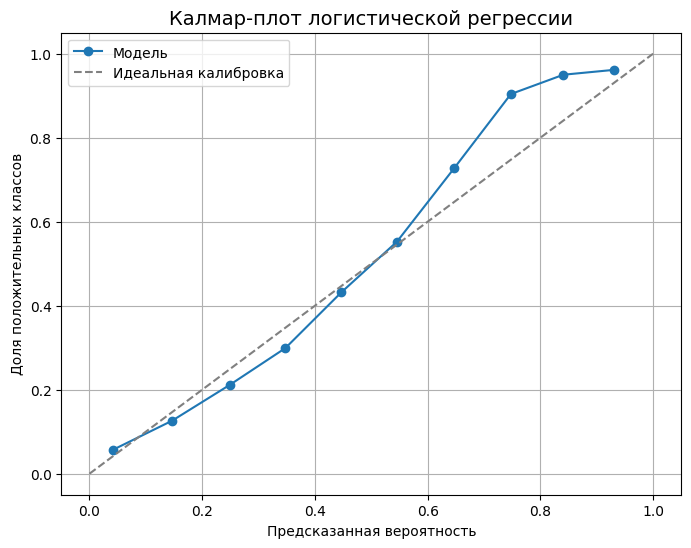

In [16]:
from sklearn.calibration import calibration_curve

# Предсказанные вероятности и фактические значения
y_pred = log_reg.predict(X_test)  # если есть тестовая выборка
y_true = y_test  # true labels

prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Модель')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.title('Калмар-плот логистической регрессии', fontsize=14)
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля положительных классов')
plt.legend()
plt.grid()
plt.show()

### Влияние переменных на вероятность одобрения кредита (коэффициенты)

Визуализация коэффициентов модели с их доверительными интервалами, чтобы показать, какие факторы сильнее всего влияют на вероятность одобрения кредита:

C:\Users\Professional\AppData\Local\Temp\ipykernel_8184\144707576.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coef', y='Variable', palette="coolwarm")


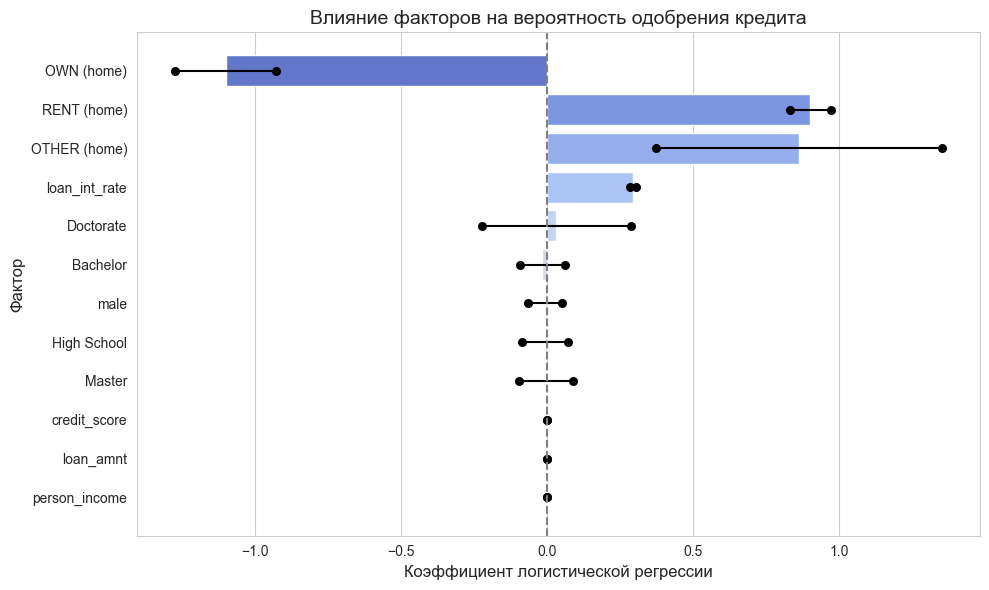

In [17]:
# Создаем DataFrame с коэффициентами и их доверительными интервалами
coef_data = {
    'Variable': ['Intercept', 'male', 'Bachelor', 'Doctorate', 'High School', 'Master', 
                 'OTHER (home)', 'OWN (home)', 'RENT (home)', 'loan_amnt', 
                 'person_income', 'loan_int_rate', 'credit_score'],
    'Coef': [-4.1762, -0.0070, -0.0163, 0.0324, -0.0056, -0.0038, 
             0.8621, -1.1003, 0.9023, 0.0001, -0.0000, 0.2951, -0.0005],
    'Lower_CI': [-4.5764, -0.0650, -0.0934, -0.2237, -0.0849, -0.0968, 
                 0.3720, -1.2740, 0.8328, 0.0001, -0.0000, 0.2842, -0.0011],
    'Upper_CI': [-3.7760, 0.0510, 0.0608, 0.2885, 0.0737, 0.0891, 
                 1.3522, -0.9267, 0.9718, 0.0001, -0.0000, 0.3060, 0.0001]
}
coef_df = pd.DataFrame(coef_data)

# Исключаем Intercept для лучшей читаемости (его масштаб слишком большой)
coef_df = coef_df[coef_df['Variable'] != 'Intercept']

# Сортируем по абсолютному значению коэффициента
coef_df['Abs_Coef'] = coef_df['Coef'].abs()
coef_df = coef_df.sort_values('Abs_Coef', ascending=False)

# Строим график
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=coef_df, x='Coef', y='Variable', palette="coolwarm")

# Добавляем доверительные интервалы
for i, (lower, upper) in enumerate(zip(coef_df['Lower_CI'], coef_df['Upper_CI'])):
    plt.plot([lower, upper], [i, i], color='black', linewidth=1.5)
    plt.scatter([lower, upper], [i, i], color='black', s=30)

plt.axvline(0, color='gray', linestyle='--')
plt.title('Влияние факторов на вероятность одобрения кредита', fontsize=14)
plt.xlabel('Коэффициент логистической регрессии', fontsize=12)
plt.ylabel('Фактор', fontsize=12)
plt.tight_layout()
plt.show()

### Важность переменных (по абсолютным значениям коэффициентов)

Какие переменные имеют наибольшее влияние на модель:

C:\Users\Professional\AppData\Local\Temp\ipykernel_8184\574408793.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Abs_Coef', y='Variable', palette="viridis")


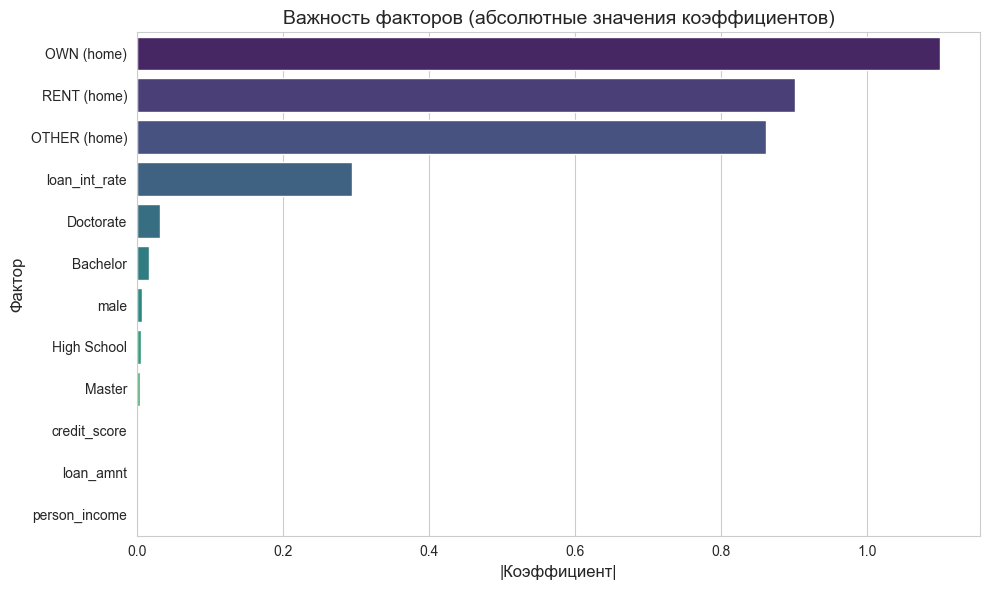

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Abs_Coef', y='Variable', palette="viridis")
plt.title('Важность факторов (абсолютные значения коэффициентов)', fontsize=14)
plt.xlabel('|Коэффициент|', fontsize=12)
plt.ylabel('Фактор', fontsize=12)
plt.tight_layout()
plt.show()

### Влияние процентной ставки (loan_int_rate) на вероятность одобрения:
(из описательной статистики мы знаем, что мин.ставка ~5%, mean ~11%, max ~20%)

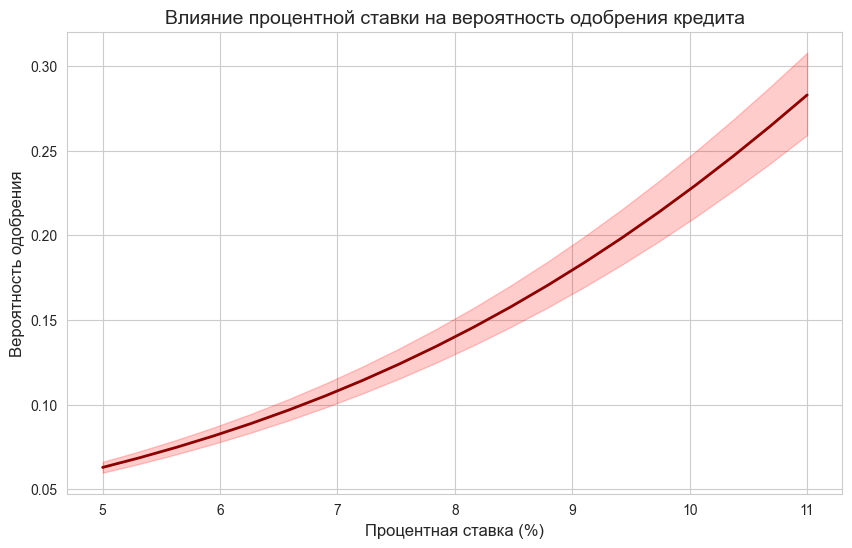

In [19]:
# Генерируем предсказания для loan_int_rate при фиксированных других переменных
int_rates = np.linspace(5, 11, 20)  # примерный диапазон ставок
log_odds = -4.1762 + 0.2951 * int_rates  # примерная модель (без других факторов)
probabilities = 1 / (1 + np.exp(-log_odds))  # преобразуем в вероятность

plt.figure(figsize=(10, 6))
plt.plot(int_rates, probabilities, color='darkred', linewidth=2)
plt.fill_between(int_rates, 
                 1 / (1 + np.exp(-(-4.1762 + 0.2842 * int_rates))),  # нижний дов. интервал
                 1 / (1 + np.exp(-(-4.1762 + 0.3060 * int_rates))),  # верхний дов. интервал
                 color='red', alpha=0.2)
plt.title('Влияние процентной ставки на вероятность одобрения кредита', fontsize=14)
plt.xlabel('Процентная ставка (%)', fontsize=12)
plt.ylabel('Вероятность одобрения', fontsize=12)
plt.grid(True)
plt.show()

### Сравнение типов жилья (person_home_ownership)

C:\Users\Professional\AppData\Local\Temp\ipykernel_8184\128934635.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=home_ownership, y=coefs, palette="Set2")


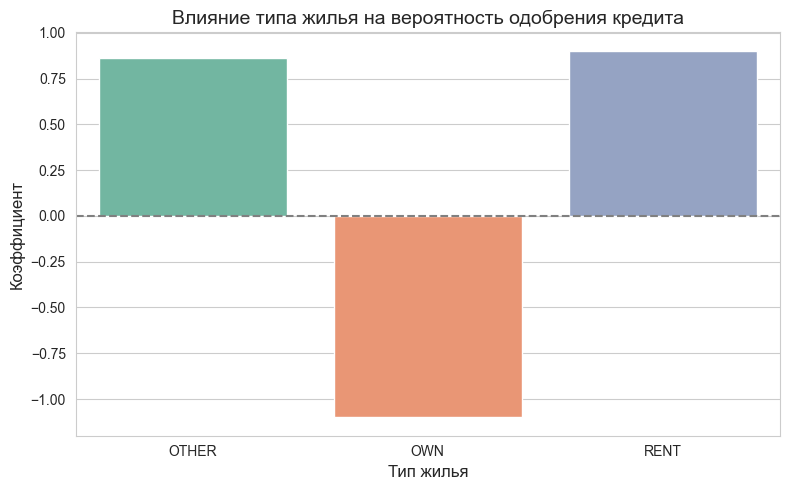

In [20]:
home_ownership = ['OTHER', 'OWN', 'RENT']
coefs = [0.8621, -1.1003, 0.9023]

plt.figure(figsize=(8, 5))
sns.barplot(x=home_ownership, y=coefs, palette="Set2")
plt.title('Влияние типа жилья на вероятность одобрения кредита', fontsize=14)
plt.xlabel('Тип жилья', fontsize=12)
plt.ylabel('Коэффициент', fontsize=12)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

### Ключевые факторы, влияющие на принятие решения о выдаче кредита:

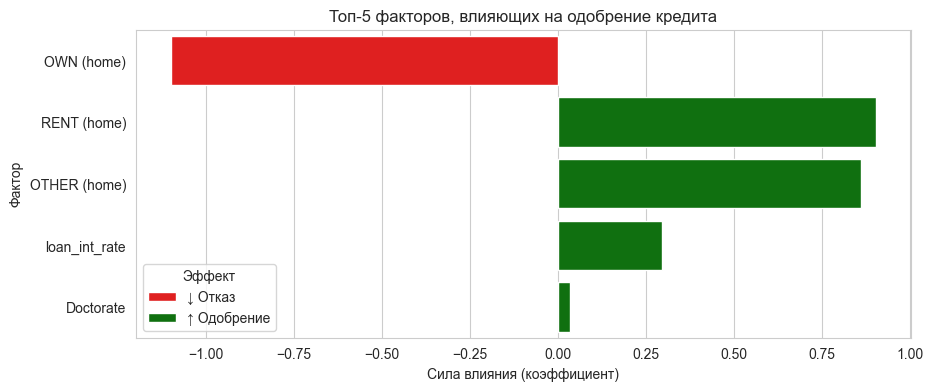

In [21]:
# Создаем датафрейм с топ-5 влияющими факторами
top_factors = coef_df.nlargest(5, 'Abs_Coef')[['Variable', 'Coef']]
top_factors['Effect'] = top_factors['Coef'].apply(lambda x: '↑ Одобрение' if x > 0 else '↓ Отказ')

# График
plt.figure(figsize=(10, 4))
sns.barplot(data=top_factors, x='Coef', y='Variable', hue='Effect', palette=['red', 'green'], dodge=False)
plt.title('Топ-5 факторов, влияющих на одобрение кредита')
plt.xlabel('Сила влияния (коэффициент)')
plt.ylabel('Фактор')
plt.legend(title='Эффект')
plt.show()